# Itinerant dynamics with the PC-RNN-HC-M model

This notebook provides the necessary source code to simulate itinerant dynamics using a trained PC-RNN-HC-M model. The model is first trained to generate three cyclic patterns using BPTT. We use the Gaussian mixture prior distribution on the hidden causes to randomly switch between the three learned behaviors, we call such dynamics itinerant.

In [1]:
import numpy as np
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import torch
from torch import nn
import pickle as pk

from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

## Model definition

This model is an RNN with an additionnal hidden causes layer. The hidden causes have a multiplicative influence on the RNN hidden state dynamics. Basically, a certain value of the hidden causes can be seen as picking a certain recurrent weights matrix. The model also features bottom-up connection patterns, allowing to infer the hidden state and hidden causes based on the prediction error on the bottom (output) level. Finally, it implements the influence of a Gaussian mixture prior distribrution onto the hidden causes. At each time step, the hidden causes values are pulled towards values that maximize this prior distribution.

In [2]:
class PC_RNN_HC_M(nn.Module):
    
    def __init__(self, causes_dim, states_dim, output_dim, factor_dim, tau_h, alpha_x, alpha_h):
        super(PC_RNN_HC_M, self).__init__()
        
        self.causes_dim = causes_dim
        self.output_dim = output_dim
        self.states_dim = states_dim
        self.factor_dim = factor_dim
        self.tau_h = tau_h  # Time constant of the network
        self.alpha_x = alpha_x  # Update rate coefficient of the hidden state layer
        self.alpha_h = alpha_h  # Update rate coefficient of the hidden causes (input) layer
        
        # Output weights initialization
        self.w_o = torch.randn(self.output_dim, self.states_dim) *5 / self.states_dim
        self.b_o = torch.randn(self.output_dim) / 10
        
        # Recurrent weights initialization
        self.w_pd = torch.randn(self.states_dim, self.factor_dim) / np.sqrt(self.factor_dim)
        self.w_fd = torch.randn(self.states_dim, self.factor_dim) / np.sqrt(self.factor_dim)
        self.w_cd = torch.nn.Softmax(1)(0.5*torch.randn(self.causes_dim, self.factor_dim))*self.factor_dim
        self.b_r = torch.randn(self.states_dim) / 10
        
        # Predictions, states and errors are temporarily stored for batch learning
        # Learning can be performed online, but computations are slower
        self.x_pred = None
        self.error = None
        self.h_prior = None
        self.h_post = None
        self.c = None
        
    def forward(self, x, c_init, h_init=0, store=True, itinerancy=False):
        """
        Pass through the network : forward (prediction) and backward (inference) passes are 
         performed at the same time. Online learning could be performed here, but to improve
         computations speed, we use the seq_len as a batch dimension in a separate function.
        Parameters :        
        - x : target sequences, Tensor of shape (seq_len, batch_size, output_dim)
        - c_init : initial hidden causes (input), Tensor of shape (batch_size, states_dim)
        - h_init : initial hidden state, Tensor of shape (batch_size, states_dim)
        - store : whether to store as attributes the different activations, should be set to
            True if learning is going to be performed on the target sequence, Boolean
        """

        seq_len, batch_size, _ = x.shape
        
        # Temporary storing of the predictions, states and errors
        if store:
            x_preds = torch.zeros(seq_len, batch_size, self.output_dim)
            h_priors = torch.zeros(seq_len, batch_size, self.states_dim)
            h_posts = torch.zeros(seq_len+1, batch_size, self.states_dim)
            cs = torch.zeros(seq_len+1, batch_size, self.causes_dim)
            error_hs = torch.zeros(seq_len, batch_size, self.states_dim)
        errors = torch.zeros(seq_len, batch_size, self.output_dim)
        
        # Initial hidden state and hidden causes
        old_h_post = h_init
        c = c_init
        
        if store:
            cs[0] = c
            h_posts[0] = old_h_post
        
        for t in range(seq_len):
            
            # In itinerancy mode, sigma_c depends on the timestep
            rnn.sigma_c = 0.2 * np.exp(2*np.sin(t/200))
            
            # Top-down pass
            
            # Compute h_prior according to past h_post
            h_prior = (1-1/self.tau_h) * old_h_post + (1/self.tau_h) * (
                torch.mm(
                    torch.mm(
                        torch.tanh(old_h_post),
                        self.w_pd
                    ) * torch.mm(
                        c,
                        self.w_cd
                    ),
                    self.w_fd.T
                ) + self.b_r.unsqueeze(0).repeat(batch_size, 1)
            )
            if store:
                h_priors[t] = h_prior.detach()
            
            # Compute x_pred according to h_prior
            x_pred =  torch.mm(torch.tanh(h_prior), self.w_o.T) + self.b_o.unsqueeze(0).repeat(batch_size, 1)
            if store:
                x_preds[t] = x_pred.detach()
            
            # Compute the error on the sensory level
            error = x_pred - x[t]
            errors[t] = error

            # Bottom-up pass
            if self.alpha_x>0:
            
                # Infer h_post according to h_prior and the error on the sensory level
                h_post = h_prior - self.alpha_x*(1-torch.tanh(h_prior)**2)*torch.mm(error.detach(), self.w_o)
                if store:
                    h_posts[t+1] = h_post.detach()

                # Compute the error on the hidden state level
                error_h = h_prior - h_post
                if store:
                    error_hs[t] = error_h.detach()

                # Infer c according to its past value and the error on the hidden state level
                c = c - self.alpha_h*torch.mm(
                    torch.mm(
                        torch.tanh(old_h_post),
                        self.w_pd
                    )* torch.mm(
                        error_h.detach(),
                        self.w_fd
                    ),
                    self.w_cd.T
                )
                
                old_h_post = h_post
                
            else:
                old_h_post = h_prior
        
            # Apply some noise to c, weighted by the norm of the error on the hidden layer
            c = c + torch.randn_like(c) * self.sigma_r
        
            if self.alpha_c > 0:
                c = c + self.alpha_c * self.complexity(c.detach())
                
            # In itinerancy mode, we adjust C to correspond to a multinomial distribution
            if itinerancy:
                c = torch.max(torch.zeros_like(c), torch.min(torch.ones_like(c), c))
                c = c / (1e-5 + torch.sum(c, axis=1))
        
            if store:
                cs[t+1] = c
        
        if store:
            self.error = errors.detach()
            self.x_pred = x_preds
            self.error_h = error_hs
            self.h_prior = h_priors
            self.h_post = h_posts
            self.c = cs
                             
        return errors

    def complexity(self, c):
        """
        Computes the gradient of the complexity term of the free energy principle with regard to the prior on c
        Parameters:
        - c : Hidden causes : Tensor of shape (batch_size, causes_dim)
        """
        
        batch_size, causes_dim = c.shape
        p = self.mus.shape[0]
        sigma_c = self.sigma_c
    
        mus = self.mus.unsqueeze(0).repeat(batch_size, 1, 1).reshape(batch_size*p, 1, causes_dim).transpose(1, 2)
        # Tensor of shape (batch_size*p, causes_dim, 1)
        
        c = c.unsqueeze(1).repeat(1, p, 1).reshape(batch_size*p, 1, causes_dim).transpose(1, 2)
        # Tensor of shape (batch_size*p, causes_dim, 1)
        
        exp = 1e-40 + torch.exp(-torch.bmm((c-mus).transpose(1, 2), c-mus)/(2*sigma_c**2))
        # Tensor of shape(batch_size*p, 1, 1)
        
        num = torch.sum(
            ((c - mus) * exp.repeat(1, causes_dim, 1)) \
                .reshape(batch_size*p, causes_dim).reshape(batch_size, p, causes_dim),
            axis=1
        )
        # Tensor of shape(batch_size, causes_dim)
        
        den = torch.sum(exp.reshape(batch_size, p), axis=1) * (2 * self.sigma_c**2)
        # Tensor of shape (batch_size)
        
        return -num/den.unsqueeze(-1).repeat(1, causes_dim)

## Dataset

We create a simple data set composed of three cyclic patterns in 2D: a square, a triangle and a circle. The period of the patterns is of 60 time steps, the patterns in the data set last for 6000 time step, thus reproducing the pattern 100 times.

In [3]:
traj=pk.load(open('trajs.pk', 'rb'))

A single period of the patterns is displayed in the following figure :

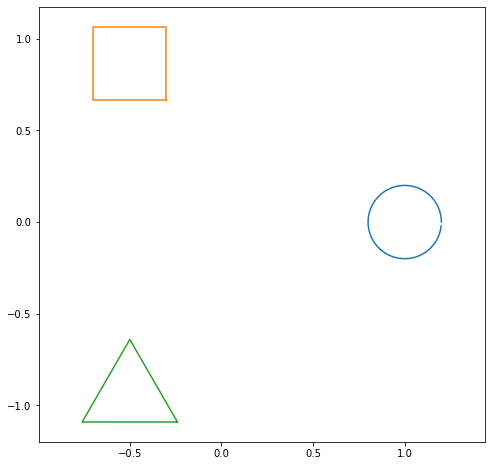

In [4]:
plt.figure(figsize=(8, 8))
pbegin=0
pend=pbegin+60
p=3
for k in range(p):
    plt.plot(traj[pbegin:pend, k, 0], traj[pbegin:pend, k, 1])
plt.axis('equal')
plt.show()

## Model Training

The model is trained to generate these three patterns using a shared initial hidden state. However, their hidden causes are different and set as 3 the one-hot vectors (1, 0, 0), (0, 1, 0) and (0, 0, 1).

In [5]:
states_dim = 100
causes_dim = p
batch_size = p
output_dim = 2
factor_dim = 50
tau_h = 5
alpha_x = 0
alpha_h = 0
sigma_c = 0.1
rnn = PC_RNN_HC_M(causes_dim, states_dim, output_dim, factor_dim, tau_h, alpha_x, alpha_h)

# Prior influence
rnn.alpha_c=0
rnn.mus=torch.eye(p)

# Noise
rnn.sigma_r=0

# Initial hidden causes and hidden state of the RNN
c_init = torch.eye(p)

A random initialization featuring hidden state dynamics comprising limit cycles is more likely to converge properly during training. For this reason, we sample several initializations until we find one that features limit cycles for each of the three initial hidden causes:

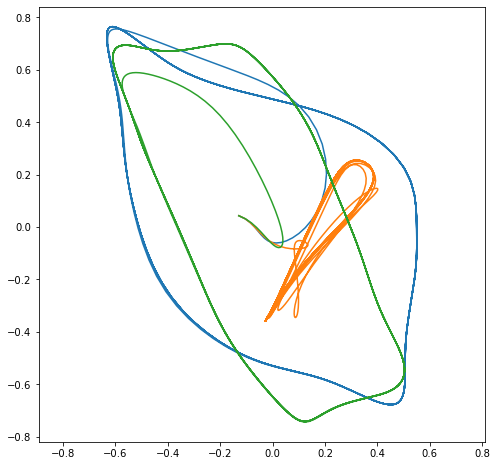

In [8]:
h_init = 0.001*torch.randn(1, rnn.states_dim).repeat(p, 1)

_ = rnn.forward(traj, c_init, h_init)

plt.figure(figsize=(8,8))
for k in range(p):
    plt.plot(rnn.x_pred[:, k, 0].detach(), rnn.x_pred[:, k, 1].detach())
plt.axis('equal')
plt.show()

We train this model to generate the target patterns. We limit training on the first 300 time steps of these patterns to speed up learning. Additionally, we do not consider the 150 first time steps in the loss function. Training is performed using backpropagation through time, with an Adam optimizer of learning rate 0.0001 and weight decay 0.00001. During training, we activate the bottom-up update of the hidden state by setting alpha_x=0.01. However, this bottom-up update is detached from the computation graph and the gradient does'nt flow backward through this computation.

Since this step can take some time, it is also possible to load a pre-trained model by skipping the two following cells.

In [9]:
rnn.alpha_x = 0.01

# Parameters to optimize with backprop
rnn.w_o=torch.nn.Parameter(rnn.w_o)
rnn.b_o=torch.nn.Parameter(rnn.b_o)
rnn.w_cd=torch.nn.Parameter(rnn.w_cd)
rnn.w_pd=torch.nn.Parameter(rnn.w_pd)
rnn.w_fd=torch.nn.Parameter(rnn.w_fd)
rnn.b_r=torch.nn.Parameter(rnn.b_r)

iterations = 5000

opt = torch.optim.Adam(rnn.parameters(), lr=0.0001, weight_decay=1e-5)
losses = []

for i in tqdm(range(iterations)):
    h = torch.randn(1, rnn.states_dim).repeat(p, 1)/1000
    opt.zero_grad()
    loss = torch.mean(rnn.forward(traj[:300], c_init, h)[150:]**2)
    loss.backward()
    opt.step()
    losses.append(loss.item())

  0%|          | 0/5000 [00:00<?, ?it/s]

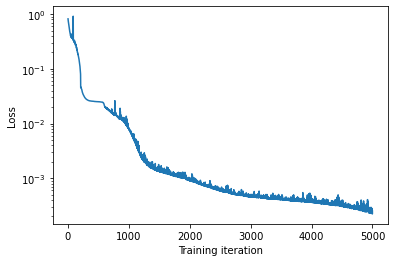

In [10]:
plt.plot(losses)
plt.yscale('log')
plt.xlabel('Training iteration')
plt.ylabel('Loss')
plt.show()

In [6]:
rnn = pk.load(open('trained_pc_rnn_hc_m.pk', 'rb'))

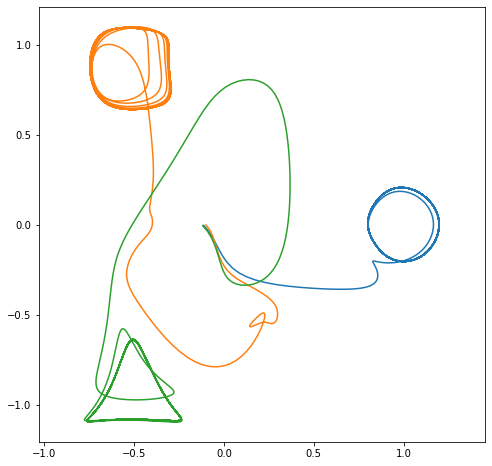

In [11]:
rnn.alpha_x = 0.0
_ = rnn.forward(traj, c_init, 0.01*torch.randn(p, rnn.states_dim))

plt.figure(figsize=(8,8))
for k in range(p):
    plt.plot(rnn.x_pred[:, k, 0].detach(), rnn.x_pred[:, k, 1].detach())
plt.axis('equal')
plt.show()

## Itinerancy simulation

Based on this trained model, we simulate itinerant dynamics, that is, dynamics that randomly switch between three learned limit cycle attractors. This behaviour emerges from the combination of two mechanisms:
- The influence of the prior distribution on the hidden causes. This influence is parametered by the variance of the Gaussian mixture prior, which varies during itinerancy. 
- An additive noise on hidden causes that ensures randomness in the transitions between the three limit cycles.

In [7]:
rnn.alpha_x = 0
rnn.alpha_h = 0
rnn.alpha_c = 0.1
rnn.sigma_r = 0.001

limit=6000

c = 1/3 + torch.randn(1, 3)*0.01
h = 0.001*torch.randn(1, rnn.states_dim)

_ = rnn.forward(torch.zeros(limit, 1, 2), c, h, itinerancy=True)

We display the complete trajectory as a continuous line in 2D. The line color varies according to the value of the hidden causes at each time step. The color 'gray' corresponds to a neutral configurations where the hidden causes value is close to (1/3, 1/3, 1/3). The colors 'red', 'green' and 'blue' correspond to the three one-hot values for the hidden causes.

We can observe that when hidden causes correspond to one of the three category, the dynamics correspond to the corresponding limit cycle attractor. On the other hand, when the hidden causes are in the neutral configuration, the corresponding dynamics have not been enforced during training and can very well feature attractors, or be chaotic. Here the dynamics corresponding to this neutral configuration seem to comprise two cyclic attractors, that can be seen in gray on the right and bottom of the figure.

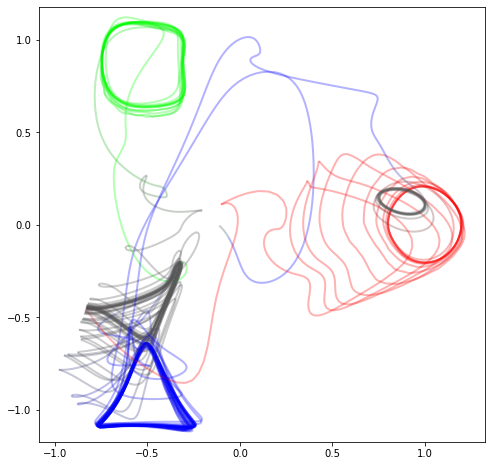

In [10]:
plt_begin = 0
plt_end =6000

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

points = np.array([rnn.x_pred[plt_begin:plt_end, 0, 0].detach().numpy(), rnn.x_pred[plt_begin:plt_end, 0, 1].detach().numpy()]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

colors = rnn.c[plt_begin:plt_end, 0, :].detach().numpy()

lc = LineCollection(segments, colors=colors, alpha=0.3, linewidth=2)

ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.add_collection(lc)
plt.axis('equal')
plt.show()


Finally, we can display the evolution of the hidden causes values during itinerancy.

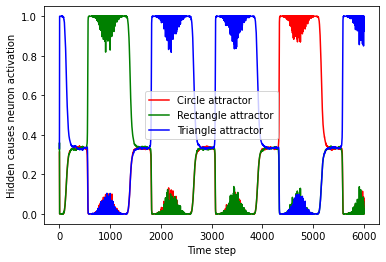

In [11]:
plt.figure(figsize=(6, 4))
plt.plot(rnn.c[:,0, 0].detach(), c='red', label='Circle attractor')
plt.plot(rnn.c[:,0, 1].detach(), c='green', label='Rectangle attractor')
plt.plot(rnn.c[:,0, 2].detach(), c='blue', label='Triangle attractor')
plt.legend()
plt.xlabel("Time step")
plt.ylabel("Hidden causes neuron activation")
plt.show()